Problem Description
 
Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

Data Description 

The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

NYC Taxi Data.csv - the training set (contains 1458644 trip records)

Data fields

id - a unique identifier for each trip

vendor_id - a code indicating the provider associated with the trip record

pickup_datetime - date and time when the meter was engaged

dropoff_datetime - date and time when the meter was disengaged

passenger_count - the number of passengers in the vehicle (driver entered value)

pickup_longitude - the longitude where the meter was engaged

pickup_latitude - the latitude where the meter was engaged

dropoff_longitude - the longitude where the meter was disengaged

dropoff_latitude - the latitude where the meter was disengaged

store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip

trip_duration - duration of the trip in seconds


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import time
import random 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

from shapely.geometry import Point,Polygon
import descartes

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
# Importing the dataset
df_taxi = pd.read_csv('/content/drive/MyDrive/NYC Taxi Data.csv')

In [62]:
df_taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [63]:
#Shape of the dataset
df_taxi.shape

(1458644, 11)

In [64]:
#Data Type of features for dataset
df_taxi.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [65]:
# converting into datetime object
df_taxi['pickup_datetime'] = pd.to_datetime(df_taxi['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
df_taxi['dropoff_datetime'] = pd.to_datetime(df_taxi['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')
df_taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [66]:
#Data Type of features for dataset
df_taxi.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object

In [67]:
#Info of the dataset
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [68]:
#Checking for null values in dataset
df_taxi.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

No missing values in the data set

In [69]:
#Checking Date and Time range
print('Datetime range: {} to {}'.format(df_taxi.pickup_datetime.min(),df_taxi.dropoff_datetime.max()))

Datetime range: 2016-01-01 00:00:17 to 2016-07-01 23:02:03


data is from janaury 2016 to june 2016

In [70]:
#Checking no. of vendors
df_taxi['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

In [71]:
#Checking Passenger count
print('Passenger Count: {} to {}'.format(df_taxi.passenger_count.min(),df_taxi.passenger_count.max()))

Passenger Count: 0 to 9


In [72]:
#The distribution of Pickup and Drop Off day of the week
print(df_taxi['pickup_datetime'].nunique())
print(df_taxi['dropoff_datetime'].nunique())

1380222
1380377


Descriptive Statistics of the dataset

In [73]:
df_taxi.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


​
Lets have a look at the distribution of various variables in the Data set

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



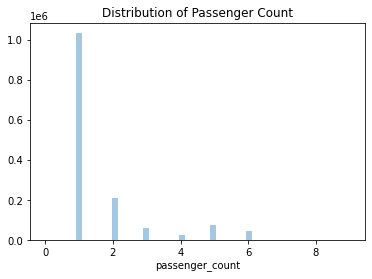

In [74]:
#Passenger Count
sns.distplot(df_taxi['passenger_count'],kde=False)
plt.title('Distribution of Passenger Count')
plt.show()

Here we can see that mostly 1 or 2 passengers avail the taxi. The instance of large group of people travelling together is rare.

Lets create some features from datetime stamp

In [75]:
#Creating pickup and dropoff day
df_taxi['pickup_day']=df_taxi['pickup_datetime'].dt.day_name()
df_taxi['dropoff_day']=df_taxi['dropoff_datetime'].dt.day_name()

In [76]:
#Creating pickup and dropoff month
df_taxi['pickup_month']=df_taxi['pickup_datetime'].dt.month
df_taxi['dropoff_month']=df_taxi['dropoff_datetime'].dt.month

In [77]:
#Creating pickup and dropoff hour
df_taxi['pickup_hour']=df_taxi['pickup_datetime'].dt.hour
df_taxi['dropoff_hour']=df_taxi['dropoff_datetime'].dt.hour

In [78]:
df_taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day,pickup_month,dropoff_month,pickup_hour,dropoff_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,3,3,17,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,6,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,1,1,11,12
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,4,4,19,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,3,3,13,13


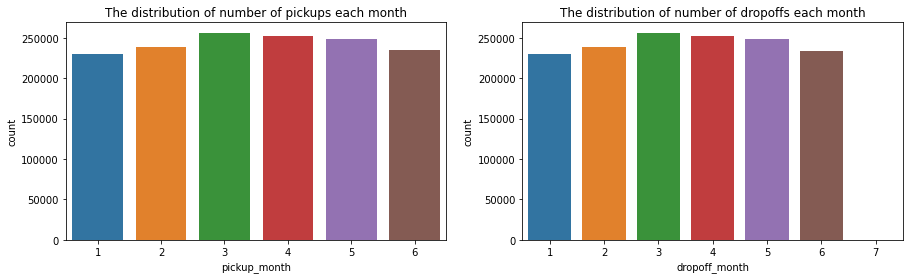

In [79]:
#Plotting monthly Pickup and Dropoff trip distribution
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,4))
sns.countplot(x='pickup_month',data=df_taxi,ax=ax[0])
ax[0].set_title('The distribution of number of pickups each month')
sns.countplot(x='dropoff_month',data=df_taxi,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs each month')
plt.show()

There is not so much of difference in Pickup and dropoff month

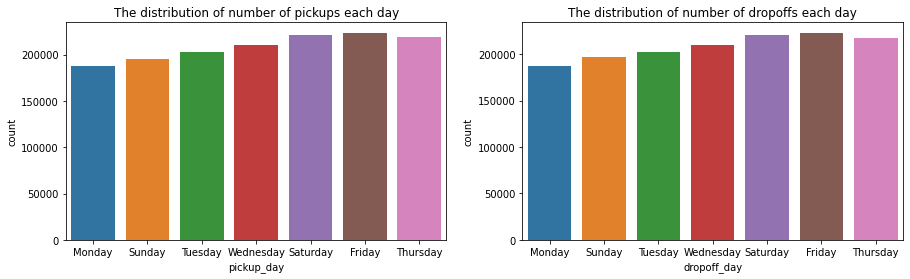

In [80]:
#Plotting daily Pickup and Dropoff trip distribution
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,4))
sns.countplot(x='pickup_day',data=df_taxi,ax=ax[0])
ax[0].set_title('The distribution of number of pickups each day')
sns.countplot(x='dropoff_day',data=df_taxi,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs each day')
plt.show()

We can see most trips were taken on Friday & least trips were taken on Monday

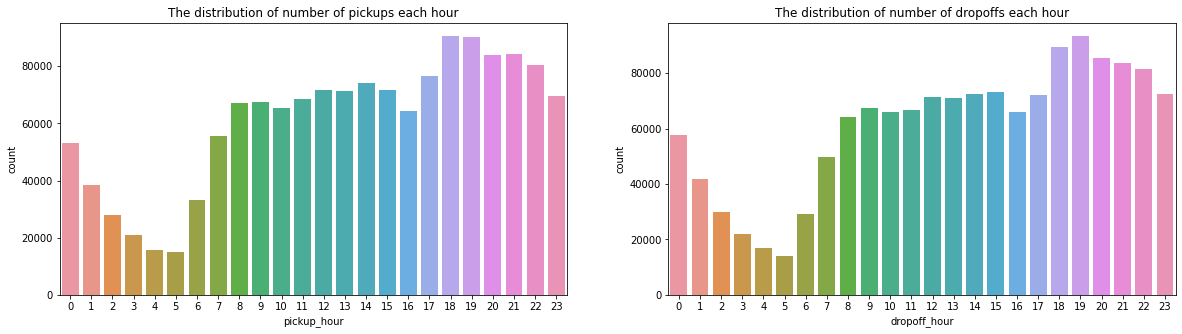

In [81]:
#Plotting hourly Pickup and Dropoff trip distribution
figure,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
sns.countplot(x='pickup_hour',data=df_taxi,ax=ax[0])
ax[0].set_title('The distribution of number of pickups each hour')
sns.countplot(x='dropoff_hour',data=df_taxi,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs each hour')
plt.show()

In [82]:
#Creating a new column according to the traffic scenerio of New York
def rush_hour(hour):
    if hour.item()>=7 and hour.item()<=9:
        return 'rush_hour_morning(7-9)'
    elif hour.item()>9 and hour.item()<16:
        return 'normal_hour_afternoon(9-16)'
    elif hour.item()>=16 and hour.item()<=19:
        return 'rush_hour_evening(16-19)'
    elif hour.item()>19 and hour.item()<=23:
        return 'normal_hour_evining(19-23)'
    else:
        return 'latenight(23 onwards)'
df_taxi['traffic_scenerio_pickup']=df_taxi[['pickup_hour']].apply(rush_hour, axis=1)
df_taxi['traffic_scenerio_dropoff']=df_taxi[['dropoff_hour']].apply(rush_hour, axis=1)

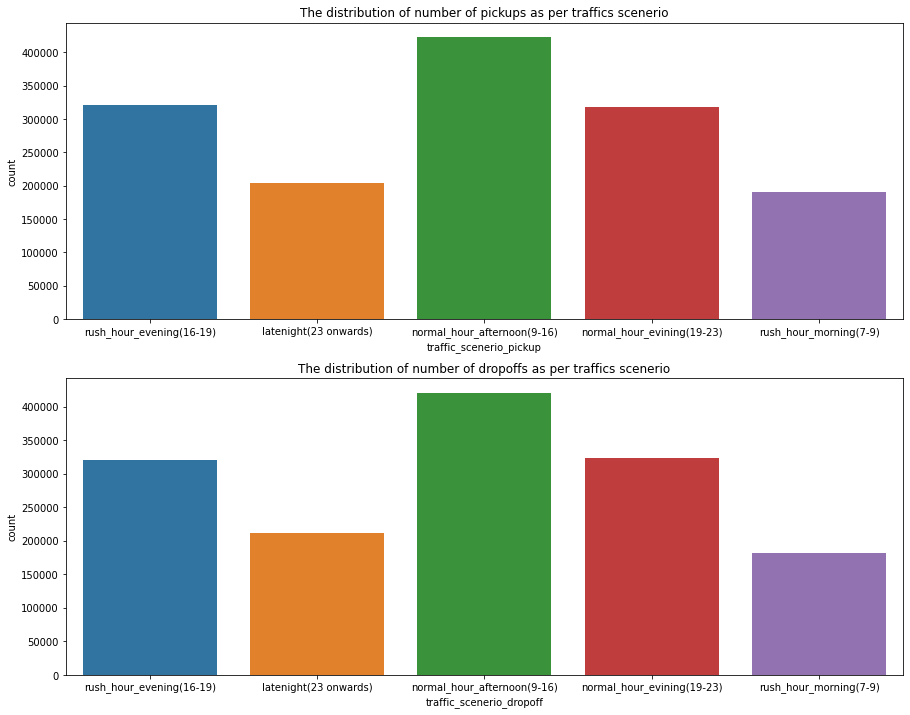

In [83]:
#Plotting pickup and dropoff trip distribution as per traffic scenerio
figure,ax=plt.subplots(nrows=2,ncols=1,figsize=(15,12))
sns.countplot(x='traffic_scenerio_pickup',data=df_taxi,ax=ax[0])
ax[0].set_title('The distribution of number of pickups as per traffics scenerio')
sns.countplot(x='traffic_scenerio_dropoff',data=df_taxi,ax=ax[1])
ax[1].set_title('The distribution of number of dropoffs as per traffics scenerio')
plt.show()


In [84]:
trip_duration = ['trip_duration']

In [85]:
def UVA_numeric(df_taxi, var_group):
    size = len(var_group)
    plt.figure(figsize = (7*size,3), dpi = 100)
    for j,i in enumerate(var_group):
        mini = df_taxi[i].min()
        maxi = df_taxi[i].max()
        mean = df_taxi[i].mean()
        median = df_taxi[i].median()
        st_dev = df_taxi[i].std()
        skew = df_taxi[i].skew()
        kurt = df_taxi[i].kurtosis()
        points = mean-st_dev, mean+st_dev
        plt.subplot(1,size,j+1)
        sns.kdeplot(df_taxi[i], shade=True)
        sns.lineplot(points, [0,0], color = 'black', label = "std_dev")
        sns.scatterplot([mini,maxi], [0,0], color = 'orange', label= "min/max")
        sns.scatterplot([mean], [0], color = 'red', label = "mean")
        sns.scatterplot([median], [0], color = 'blue', label = "median")
        plt.xlabel('{}'.format(i), fontsize = 20)
        plt.ylabel('density')
        plt.title('std_dev = {}; kurtosis = {};\nskew = {}; range = {};\nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                        round(kurt,2),
                                                                                        round(skew,2),
                                                                                        (round(mini,2),round(maxi,2)),
                                                                                        round(mean,2),
                                                                                        round(median,2)))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning

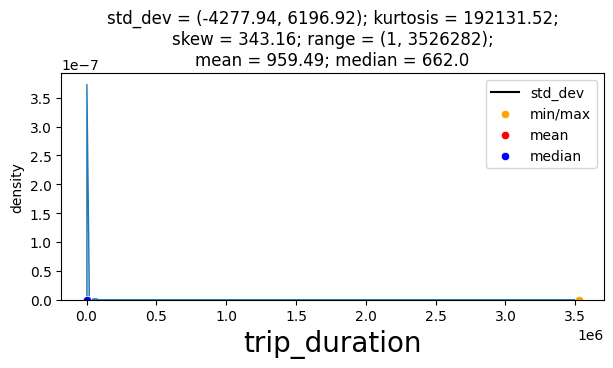

In [86]:
UVA_numeric(df_taxi, trip_duration)

This shows extreme right skewness, hence there are outliers.

Lets see the boxplots of this variable.

We can see there are few outliers, which we have to treat.

IQR to treat outliers

In [87]:
df_taxi.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,dropoff_month,pickup_hour,dropoff_hour
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,3.516818e+00,3.517178e+00,1.360648e+01,1.359890e+01
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,1.681038e+00,1.681217e+00,6.399693e+00,6.483682e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,2.000000e+00,2.000000e+00,9.000000e+00,9.000000e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,4.000000e+00,4.000000e+00,1.400000e+01,1.400000e+01
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,5.000000e+00,5.000000e+00,1.900000e+01,1.900000e+01
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,6.000000e+00,7.000000e+00,2.300000e+01,2.300000e+01


In [89]:
df_taxi1 = df_taxi.drop(['pickup_datetime','dropoff_datetime'],axis=1)

In [90]:
df_taxi1.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,dropoff_day,pickup_month,dropoff_month,pickup_hour,dropoff_hour,traffic_scenerio_pickup,traffic_scenerio_dropoff
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,Monday,3,3,17,17,rush_hour_evening(16-19),rush_hour_evening(16-19)
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,Sunday,6,6,0,0,latenight(23 onwards),latenight(23 onwards)
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,Tuesday,1,1,11,12,normal_hour_afternoon(9-16),normal_hour_afternoon(9-16)
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,Wednesday,4,4,19,19,rush_hour_evening(16-19),rush_hour_evening(16-19)
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,Saturday,3,3,13,13,normal_hour_afternoon(9-16),normal_hour_afternoon(9-16)


In [91]:
Q1 = df_taxi1.quantile(0.25)
Q3 = df_taxi1.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

vendor_id              1.000000
passenger_count        1.000000
pickup_longitude       0.024536
pickup_latitude        0.031013
dropoff_longitude      0.028313
dropoff_latitude       0.033925
trip_duration        678.000000
pickup_month           3.000000
dropoff_month          3.000000
pickup_hour           10.000000
dropoff_hour          10.000000
dtype: float64


In [92]:
print((df_taxi1 < (Q1 - 1.5 * IQR)) | (df_taxi1 > (Q3 + 1.5 * IQR)))

         dropoff_day  dropoff_hour  ...  trip_duration  vendor_id
0              False         False  ...          False      False
1              False         False  ...          False      False
2              False         False  ...           True      False
3              False         False  ...          False      False
4              False         False  ...          False      False
...              ...           ...  ...            ...        ...
1458639        False         False  ...          False      False
1458640        False         False  ...          False      False
1458641        False         False  ...          False      False
1458642        False         False  ...          False      False
1458643        False         False  ...          False      False

[1458644 rows x 17 columns]


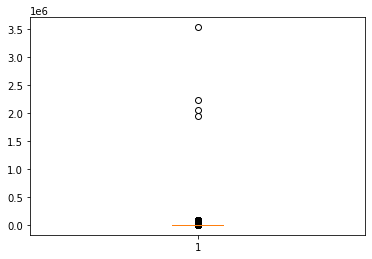

In [93]:
plt.boxplot(df_taxi1["trip_duration"])
plt.show()

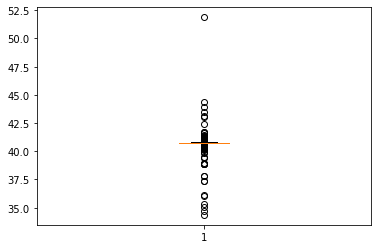

In [97]:
plt.boxplot(df_taxi1["pickup_latitude"])
plt.show()

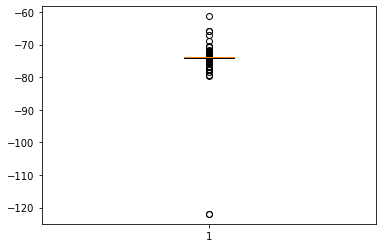

In [99]:
plt.boxplot(df_taxi1["pickup_longitude"])
plt.show()

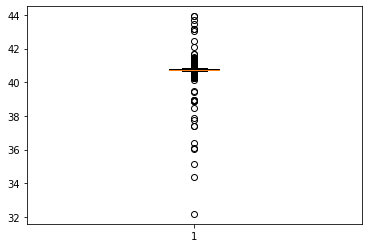

In [100]:
plt.boxplot(df_taxi1["dropoff_latitude"])
plt.show()

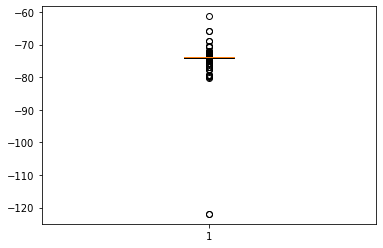

In [101]:
plt.boxplot(df_taxi1["dropoff_longitude"])
plt.show()

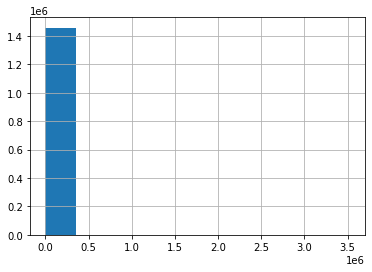

In [95]:
df_taxi1.trip_duration.hist()

We can see there are few outliers, which we have to treat.

In [102]:
#Dropping trip_duration <1 min
df_taxi= df_taxi[df_taxi.trip_duration>60] # >1 min

In [103]:
#Dropping trip_duration >2 Hrs
df_taxi= df_taxi[df_taxi.trip_duration<=7200] # >2 hrs

Removed trip duration of less than 1 min and greater than 2 hrs as its not looking sensible that one can hire taxi for less than a min or more that 2 hrs in a city like New York!

Distribution of vendor_id

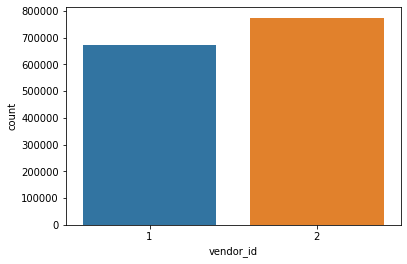

In [104]:
sns.countplot(x='vendor_id',data=df_taxi)

The distribution of vendor id is not much different.

Analysing geographical boundary of NYC

In [105]:
#Checking Longitude and Lattitude bounds available in the data
print('Longitude Bounds: {} to {}'.format(max(df_taxi.pickup_longitude.min(),df_taxi.dropoff_longitude.min()),max(df_taxi.pickup_longitude.max(),df_taxi.dropoff_longitude.max())))
print('Lattitude Bounds: {} to {}'.format(max(df_taxi.pickup_latitude.min(),df_taxi.dropoff_latitude.min()),max(df_taxi.pickup_latitude.max(),df_taxi.dropoff_latitude.max())))

Longitude Bounds: -121.9333038330078 to -61.33552932739258
Lattitude Bounds: 34.359695434570305 to 51.88108444213867


In [106]:
#The borders of NY City, in coordinates comes out to be: city_long_border = (-74.03, -73.75) & city_lat_border = (40.63, 40.85)
#Comparing this to our 'df_taxi.describe()' output we see that there are some coordinate points (pick ups/drop offs) that fall outside these borders. So let's limit our area of investigation to within the NY City borders.
df_taxi = df_taxi[df_taxi['pickup_longitude'] <= -73.75]
df_taxi = df_taxi[df_taxi['pickup_longitude'] >= -74.03]
df_taxi = df_taxi[df_taxi['pickup_latitude'] <= 40.85]
df_taxi = df_taxi[df_taxi['pickup_latitude'] >= 40.63]
df_taxi = df_taxi[df_taxi['dropoff_longitude'] <= -73.75]
df_taxi = df_taxi[df_taxi['dropoff_longitude'] >= -74.03]
df_taxi = df_taxi[df_taxi['dropoff_latitude'] <= 40.85]
df_taxi = df_taxi[df_taxi['dropoff_latitude'] >= 40.63]

Based on Latitude and Longitude get the distance of the trip in km

This uses Haversine Distance

In [107]:
#Getting distance(in km) from geographocal co-ordinates
from math import radians, sin, cos, sqrt, asin
def haversine(columns):
    lat1, lon1, lat2, lon2 = columns
    R = 6372.8 # Earth radius in kilometers
    
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    
    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))
    
    return R * c


    

In [108]:
cols = ['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
distances = df_taxi[cols].apply(lambda x: haversine(x),axis = 1)
df_taxi['distance_km'] = distances.copy()
df_taxi['distance_km'] = round(df_taxi.distance_km,2)

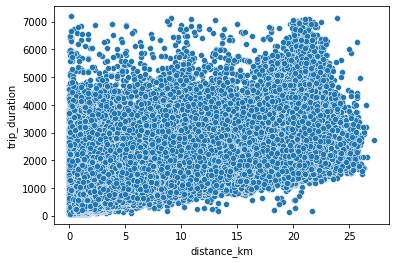

In [109]:
sns.scatterplot(x='distance_km',y='trip_duration',data=df_taxi)

In [110]:
#Removing distance Outliers
df_taxi = df_taxi[df_taxi['distance_km'] > 0]

Removed distance which have 0 value,seems to be cancelled trips.

In [111]:
#Getting Speed(Km/h) of the taxi 
df_taxi['speed_km/h']= 3600*(df_taxi.distance_km/df_taxi.trip_duration)  #3600 to convert it from km/s to km/h

In [112]:
#Checking Distance and Speed range
print('Distance Bounds: {} to {}'.format(df_taxi.distance_km.min(),df_taxi.distance_km.max()))
print('Speed Bounds: {} to {}'.format(df_taxi['speed_km/h'].min(),df_taxi['speed_km/h'].max()))

Distance Bounds: 0.01 to 27.2
Speed Bounds: 0.005539313740575473 to 584.0330578512397


In [113]:
#Removing speed Outliers
df_taxi = df_taxi[df_taxi['speed_km/h'] > 0]
df_taxi = df_taxi[df_taxi['speed_km/h'] < 100]

Removed average speed equals to zero and more than 100, as its seems to be outliers.

In [114]:
#Dropping passenger count=0
df_taxi= df_taxi[df_taxi.passenger_count>0]
df_taxi['passenger_count'].value_counts()

1    1009190
2     205377
5      76365
3      58594
6      47222
4      27730
Name: passenger_count, dtype: int64

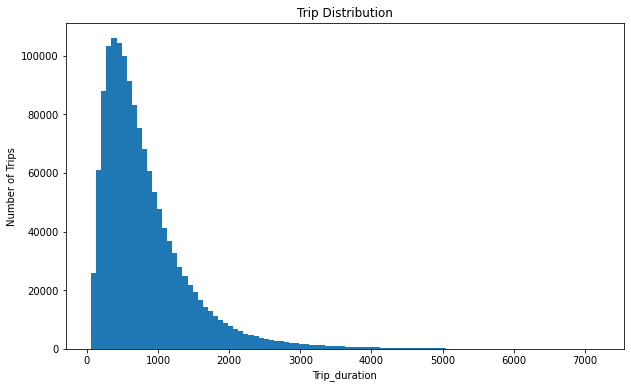

In [115]:
#Plotting Trip Distribution
plt.figure(figsize=(10,6))
plt.hist(df_taxi.trip_duration, bins=100)
plt.xlabel('Trip_duration')
plt.ylabel('Number of Trips')
plt.title('Trip Distribution')
plt.show()

Seems the distribution is skewed so we can apply certain transforms such as log transform!

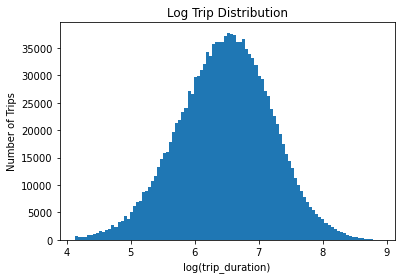

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



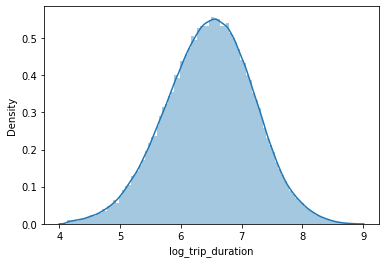

In [116]:
#Applying Feature Scaling in trip_duration caloumn to normalize the data
df_taxi['log_trip_duration']= np.log1p(df_taxi['trip_duration'])
plt.hist(df_taxi['log_trip_duration'].values, bins=100)
plt.title('Log Trip Distribution')
plt.xlabel('log(trip_duration)')
plt.ylabel('Number of Trips')
plt.show()
sns.distplot(df_taxi["log_trip_duration"], bins =100)